<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Modeling Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 Libraries</h3>
</div>

In [1]:
## General
import re
import pandas as pd
import numpy as np

## Scikit Learn library
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## LightGBM
from lightgbm import LGBMClassifier

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's load the current clients
   </p>
</div>

In [2]:
df_current_clients = pd.read_csv(r"datasets\finals_datasets\df_current_clients.csv", nrows=30000)

In [3]:
df_analysis(df_current_clients, "df_current_clients", analysis_type="header")


Analysis Header of df_current_clients dataset
--------------------------------------------------------------------------------
- Dataset shape:			 30000 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 116.5 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>After making the preprocessing, we achieved 0.0% of missing-values.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [4]:
df_current_clients = memory_optimization(df_current_clients)

In [5]:
df_analysis(df_current_clients, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 30000 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 45.5 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The memory usage has been reduced.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyzing target variable</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the target variable to see whether is an imbalanced class
   </p>
</div>

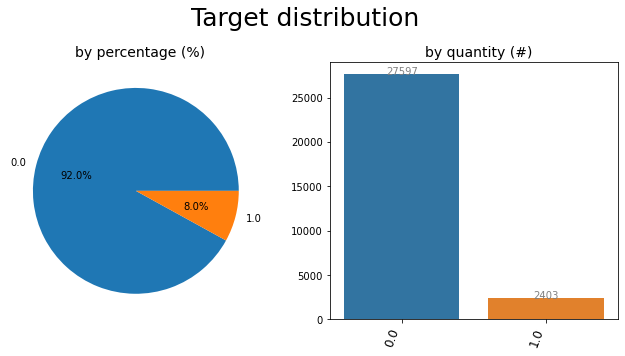

In [6]:
barplot_and_pie(df_current_clients["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Splitting data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's identify the training columns in the dataset
   </p>
</div>

In [7]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

<div class="alert alert-block alert-info">
    <p>Now, we are going to split the data
   </p>
</div>

In [8]:
X = df_current_clients[TRAINING_COLUMNS]

In [9]:
y_target = df_current_clients.loc[:,"TARGET"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, random_state=42)

In [11]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (24000, 506)
y_train: (24000,)
---------------------
X_test: (6000, 506)
y_test: (6000,)


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Modelisation</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to face an <b>Unbalanced Classification Problem</b> and we are going to use three models</p>
    <ul style="list-style-type: square;">
        <li>Random Forest Classifier</li>
        <li>Support Vector Machine</li>
        <li>LightGBM</li>
    </ul>
    <p>Also, we are going to use a Cost Function to penalize the Falses Positives</p>
    <p>So, let's define the parameters to use throughout the three models</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Parameters</h3>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1.1. Custom Score</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We need to penalize the <b>False Negative</b> that are loands <b>will be in default</b>, and they were <b>predicted incorrectly</b>. Due to that, we are going to define a <b>Custom Score</b>.
    </p>
</div>

def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -100     # Loans that are in default and were were predicted incorrectly
    
    
    
    
    
    
    
    # Getting all values based on confusion matrix
       ## (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
       ## total_not_default = TN + FP     # Not default cases
       ## total_default = TP + FN         # Default cases 
    
       ## gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
       ## gain_maximun = total_not_default*TN_rate + total_default*TP_rate
       ## gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
       ## score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    total = (TN_rate*tn + FP_rate*fp + FN_rate*fn + TP_rate*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*TN_rate + (tp + fn)*TP_rate

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*FP_rate + (tp + fn)*FN_rate

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score = (total - min_gain)/(max_gain - min_gain)

    
    return score

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1.2. Others parameters</h4>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the unbalanced class, we are going t implement OverSampling technique with SMOTE.</p>
</div>

In [12]:
smote = SMOTE(random_state=42, n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Also, we are going to use Stratified K-Folds cross-validator to ensure that each fold of dataset has the same proportion of observations with a given label.</p>
</div>

In [13]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

<div class="alert alert-block alert-info">
    <p>Finally, we are going to get the following metrics.</p>
</div>

In [66]:
SCORINGS = {
    "roc_auc" : "roc_auc",
    "recall" : "recall", 
    "f1" : "f1", 
    #"custom_score" : make_scorer(custom_score)
}

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Models</h3>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3.1. LightGBM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
    <p>We are going to use most of parameters used in the kernel selected</p>
</div>

In [62]:
lgbm = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(metric="None",
                                                       n_estimators=10000,
                                                       learning_rate=0.02,
                                                       num_leaves=34,
                                                       colsample_bytree=0.9497036,
                                                       subsample=0.8715623,
                                                       max_depth=8,
                                                       reg_alpha=0.041545473,
                                                       reg_lambda=0.0735294,
                                                       min_split_gain=0.0222415,
                                                       min_child_weight=39.3259775,
                                                       n_jobs=-1)]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [63]:
param_grid = {
    "LightGBM__n_estimators" : [10000],#"LightGBM__n_estimators" : [8000, 10000],
    #"LightGBM__num_leaves" : [32, 34], 
    #"LightGBM__max_depth" : [8, 9]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [64]:
search_lgbm = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [65]:
search_lgbm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[['Smote',
                                        SMOTE(n_jobs=-1, random_state=42)],
                                       ['LightGBM',
                                        LGBMClassifier(colsample_bytree=0.9497036,
                                                       learning_rate=0.02,
                                                       max_depth=8,
                                                       metric='None',
                                                       min_child_weight=39.3259775,
                                                       min_split_gain=0.0222415,
                                                       n_estimators=10000,
                                                       num_leaves=34,
                                                       reg_alpha=0.041545473,
                                                       reg_lambd

In [67]:
search_lgbmXX = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring=SCORINGS,
                           refit="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [68]:
search_lgbmXX.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[['Smote',
                                        SMOTE(n_jobs=-1, random_state=42)],
                                       ['LightGBM',
                                        LGBMClassifier(colsample_bytree=0.9497036,
                                                       learning_rate=0.02,
                                                       max_depth=8,
                                                       metric='None',
                                                       min_child_weight=39.3259775,
                                                       min_split_gain=0.0222415,
                                                       n_estimators=10000,
                                                       num_leaves=34,
                                                       reg_alpha=0.041545473,
                                                       reg_lambd

In [69]:
search_lgbmXX.best_score_

0.7104709302348828

In [71]:
search_lgbmXX.cv_results_

{'mean_fit_time': array([548.41478038]),
 'std_fit_time': array([0.73630843]),
 'mean_score_time': array([34.59602706]),
 'std_score_time': array([0.34061875]),
 'param_LightGBM__n_estimators': masked_array(data=[10000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'LightGBM__n_estimators': 10000}],
 'split0_test_roc_auc': array([0.71138563]),
 'split1_test_roc_auc': array([0.71083421]),
 'split2_test_roc_auc': array([0.70919295]),
 'mean_test_roc_auc': array([0.71047093]),
 'std_test_roc_auc': array([0.00093128]),
 'rank_test_roc_auc': array([1]),
 'split0_train_roc_auc': array([1.]),
 'split1_train_roc_auc': array([1.]),
 'split2_train_roc_auc': array([1.]),
 'mean_train_roc_auc': array([1.]),
 'std_train_roc_auc': array([0.]),
 'split0_test_recall': array([0.07366771]),
 'split1_test_recall': array([0.06583072]),
 'split2_test_recall': array([0.07355243]),
 'mean_test_recall': array([0.07101695]),
 'std_test_recall': array([0.00366752]

In [77]:
print(search_lgbmXX.cv_results_["mean_test_roc_auc"])
print(search_lgbmXX.cv_results_["mean_test_recall"])
print(search_lgbmXX.cv_results_["mean_test_f1"])

[0.71047093]
[0.07101695]
[0.12019363]


In [78]:

model = search_lgbmXX.best_estimator_

In [79]:
y_prob = model.predict_proba(X_test)
y_prob = y_prob[:, 1]

In [80]:
y_pred = model.predict(X_test)


In [81]:
auc_pred = metrics.roc_auc_score(y_test, y_prob)
recall_pred = metrics.recall_score(y_test, y_pred)
precision_pred = metrics.precision_score(y_test, y_pred)
f1_pred = metrics.f1_score(y_test, y_pred)

In [82]:
print(auc_pred)
print(recall_pred)
print(precision_pred)
print(f1_pred)

0.7179510724737681
0.08401639344262295
0.37962962962962965
0.13758389261744963


In [ ]:
lgbm = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(colsample_bytree=0.8,
                                                       subsample=0.8,
                                                       metric="None",
                                                       n_estimators=200,
                                                       random_state=13,
                                                       is_unbalance=False,
                                                       n_jobs=-1)]
                          ]
                 )

In [52]:
lgbmXXX = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(metric="None", 
                                                       n_estimators=10000,
                                                       learning_rate=0.02,
                                                       num_leaves=34,
                                                       colsample_bytree=0.9497036,
                                                       subsample=0.8715623,
                                                       max_depth=8,
                                                       reg_alpha=0.041545473,
                                                       reg_lambda=0.0735294,
                                                       min_split_gain=0.0222415,
                                                       min_child_weight=39.3259775,
                                                       n_jobs=-1)]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [51]:
param_grid = {
    "LightGBM__n_estimators" : [10000],#"LightGBM__n_estimators" : [8000, 10000],
    #"LightGBM__num_leaves" : [32, 34], 
    #"LightGBM__max_depth" : [8, 9]
}

In [21]:
search_lgbm = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [53]:
search_lgbmXXX = GridSearchCV(estimator=lgbmXXX,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [22]:
search_lgbm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[['Smote',
                                        SMOTE(n_jobs=-1, random_state=42)],
                                       ['LightGBM',
                                        LGBMClassifier(colsample_bytree=0.8,
                                                       is_unbalance=False,
                                                       metric='None',
                                                       n_estimators=200,
                                                       random_state=13,
                                                       subsample=0.8)]]),
             n_jobs=-1, param_grid={'LightGBM__n_estimators': [8000]},
             return_train_score=True, scoring='roc_auc')

In [54]:
search_lgbmXXX.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[['Smote',
                                        SMOTE(n_jobs=-1, random_state=42)],
                                       ['LightGBM',
                                        LGBMClassifier(colsample_bytree=0.9497036,
                                                       learning_rate=0.02,
                                                       max_depth=8,
                                                       metric='None',
                                                       min_child_weight=39.3259775,
                                                       min_split_gain=0.0222415,
                                                       n_estimators=10000,
                                                       num_leaves=34,
                                                       reg_alpha=0.041545473,
                                                       reg_lambd

In [23]:
search_lgbm.best_score_

0.7111314279000505

In [55]:
search_lgbmXXX.best_score_

0.7104709302348828

In [70]:
search_lgbmXXX.cv_results_

{'mean_fit_time': array([412.67654634]),
 'std_fit_time': array([1.375498]),
 'mean_score_time': array([14.23277831]),
 'std_score_time': array([0.2129274]),
 'param_LightGBM__n_estimators': masked_array(data=[10000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'LightGBM__n_estimators': 10000}],
 'split0_test_score': array([0.71138563]),
 'split1_test_score': array([0.71083421]),
 'split2_test_score': array([0.70919295]),
 'mean_test_score': array([0.71047093]),
 'std_test_score': array([0.00093128]),
 'rank_test_score': array([1]),
 'split0_train_score': array([1.]),
 'split1_train_score': array([1.]),
 'split2_train_score': array([1.]),
 'mean_train_score': array([1.]),
 'std_train_score': array([0.])}

In [24]:
model = search_lgbm.best_estimator_

In [56]:
modelXXX = search_lgbmXXX.best_estimator_

In [25]:
y_pred = model.predict(X_test)

In [57]:
y_predXXX = modelXXX.predict(X_test)

In [26]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [27]:
y_prob = model.predict_proba(X_test)
y_prob = y_prob[:, 1]

In [58]:
y_probXXX = modelXXX.predict_proba(X_test)
y_probXXX = y_probXXX[:, 1]

In [28]:
y_prob

array([1.03964707e-05, 3.55252451e-07, 1.18494519e-11, ...,
       3.87886269e-08, 3.74865735e-07, 1.27793274e-06])

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve


In [31]:
auc_pred = metrics.roc_auc_score(y_test, y_prob)
recall_pred = metrics.recall_score(y_test, y_pred)
precision_pred = metrics.precision_score(y_test, y_pred)
f1_pred = metrics.f1_score(y_test, y_pred)

In [32]:
print(auc_pred)
print(recall_pred)
print(precision_pred)
print(f1_pred)

0.723690784934212
0.028688524590163935
0.35
0.05303030303030304


In [59]:
auc_pred = metrics.roc_auc_score(y_test, y_probXXX)
recall_pred = metrics.recall_score(y_test, y_predXXX)
precision_pred = metrics.precision_score(y_test, y_predXXX)
f1_pred = metrics.f1_score(y_test, y_predXXX)

In [60]:
print(auc_pred)
print(recall_pred)
print(precision_pred)
print(f1_pred)

0.7179510724737681
0.08401639344262295
0.37962962962962965
0.13758389261744963


In [38]:
accuracy = metrics.accuracy_score(y_test, y_pred)

In [39]:
print(accuracy)

0.9166666666666666


In [40]:
precision = metrics.precision_score(y_test, y_pred, average='binary') 
print(precision)

0.35


In [42]:
recall = metrics.recall_score(y_test, y_pred, average='binary')
print(recall)

0.028688524590163935


In [46]:
from sklearn.metrics import PrecisionRecallDisplay

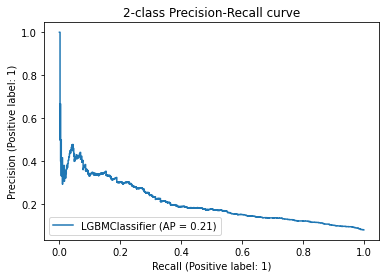

In [61]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_probXXX.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

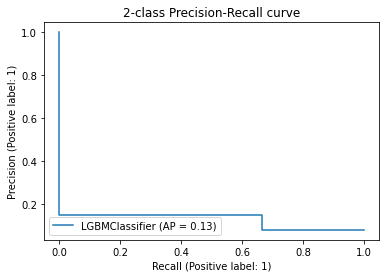

In [48]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
CCCCCCCCCCCCCCCCCCCCCCCCCcccc

In [ ]:
clf = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(colsample_bytree=0.8,
                                                       subsample=0.8, 
                                                       is_unbalance=False,
                                                       n_jobs=-1)]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000], 
}

In [ ]:
search = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring="roc_auc",
                      cv=stratified_kfold,
                      n_jobs=-1,
                      return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
search.best_score_

In [ ]:
search.cv_results_

In [ ]:
search2 = GridSearchCV(estimator=clf,
                       param_grid=param_grid,
                       scoring=SCORINGS,
                       refit="roc_auc",
                       cv=stratified_kfold,
                       n_jobs=-1,
                       return_train_score=True)

In [ ]:
search2.fit(X_train, y_train)

In [ ]:
search2.best_score_

In [ ]:
SCORINGS = {
    "roc_auc" : "roc_auc",
    "recall" : "recall", 
    "f1" : "f1", 
    "custom_score" : make_scorer(custom_score)
}

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(search2.cv_results_)

In [ ]:
# Get the results
print("Metrics based on the best ROC-AUC")
print("- ROC-AUC:\t\t", round((search2.best_score_), 3))
print("- Recall:\t\t", round(df_results.iloc[search.best_index_]["mean_test_recall"], 3))
print("- F1:\t\t\t", round(df_results.iloc[search.best_index_]["mean_test_f1"], 3))
print("- Custom Score:\t\t", round(df_results.iloc[search.best_index_]["mean_test_custom_score"], 3))
print("- Duration:\t\t", round(df_results.iloc[search.best_index_]["mean_score_time"]/3.600, 3), " minutes")
#print("- Parameters:", search.best_params_)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

In [ ]:
model = search2.best_estimator_

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_prob = model.predict_proba(X_test)
y_prob = y_prob[:, 1]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

In [ ]:
def my_colors(n=5):
    return [(sns.color_palette("viridis", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

In [ ]:
# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

<div class="alert alert-block alert-warning">
    <p>AQUI</p>
</div>

In [ ]:
lgbm = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(colsample_bytree=0.8,
                                                       subsample=0.8,
                                                       metric="None",
                                                       n_estimators=200,
                                                       random_state=13,
                                                       silent=True,
                                                       is_unbalance=False,
                                                       n_jobs=-1)]
                          ]
                 )

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000],
    "LightGBM__num_leaves" : [32, 34], 
    "LightGBM__max_depth" : [8, 9]
}

In [ ]:
search_ultimate = GridSearchCV(estimator=lgbm,
                      param_grid=param_grid,
                      scoring="roc_auc",
                      cv=stratified_kfold,
                      n_jobs=-1,
                      return_train_score=True)

In [ ]:
search_ultimate.fit(X_train, y_train)

In [ ]:
search_ultimate.best_score_

In [ ]:
model = search_ultimate.best_estimator_

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_prob = model.predict_proba(X_test)
y_prob = y_prob[:, 1]

In [ ]:
y_prob

In [ ]:
auc_pred = metrics.roc_auc_score(y_test, y_prob)
recall_pred = metrics.recall_score(y_test, y_pred)
precision_pred = metrics.precision_score(y_test, y_pred)
f1_pred = metrics.f1_score(y_test, y_pred)

In [ ]:
print(auc_pred)
print(recall_pred)
print(precision_pred)
print(f1_pred)

In [ ]:
print(custom_score(y_test, y_pred)) # valores copiados

In [ ]:
print(custom_score(y_test, y_prob)) # valores copiados

In [ ]:
print(custom_score(y_test, y_pred)) # valores copiados

In [ ]:
print(custom_score(y_test, y_prob)) # valores copiados

In [ ]:
scor_int = []
int_seuil = np.arange(0.0, 1.01, 0.01)

for s in int_seuil:
    
  # Score du modèle : 0 à 1
  y_seuil=[]

  for i in y_prob:
    if i >= s:
      y_seuil.append(1)
    elif i < s:
       y_seuil.append(0)

  #tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()
  
  scor_int.append(custom_score(y_test, y_prob))
    
# Affichage du gain en fonction du seuil de solvabilité    
plt.figure(figsize=(15, 10))
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")
plt.show()

In [ ]:
threshold_array = np.linspace(0, 1, 100)
accuracy_list = []

for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (y_pred > threshold).astype(int)
    # Calcul de l'accuracy pour un seuil donné
    accuracy_threshold = accuracy_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    accuracy_list.append(accuracy_threshold)

plt.plot(threshold_array, accuracy_list)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

In [ ]:
def my_colors(n=5):
    return [(sns.color_palette("viridis", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

In [ ]:
# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

<div class="alert alert-block alert-warning">
    <p>AQUI</p>
</div>

In [ ]:
!cat /proc/cpuinfo

In [ ]:
lgbm = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(colsample_bytree=0.8,
                                                       subsample=0.8,
                                                       metric="None",
                                                       n_estimators=200,
                                                       random_state=13,
                                                       silent=True,
                                                       is_unbalance=False,
                                                       n_jobs=-1)]
                          ]
                 )

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000],
    "LightGBM__num_leaves" : [32, 34], 
    "LightGBM__max_depth" : [8, 9]
}

In [ ]:
search_ultimate = GridSearchCV(estimator=lgbm,
                      param_grid=param_grid,
                      scoring="roc_auc",
                      cv=stratified_kfold,
                      n_jobs=-1,
                      return_train_score=True)

In [ ]:
search_ultimate.fit(X_train, y_train)

In [ ]:
search_ultimate.best_score_

<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

In [ ]:
xxxxxxxxxxx

<div class="alert alert-block alert-danger">
    <p>PRUEBA 2
   </p>
</div>

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>NO se utilizo custom score</li>
        <li>Kfold de 3 y no stratified https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7</li>
        <li>varios parametros de prueba</li>
        <li>return_train_score</li>
    </ul> 
</div>

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
pipeline = imbpipeline(steps = [['Smote', smote],
                                ['LightGBM', LGBMClassifier(colsample_bytree=0.8,
                                                            subsample=0.8, is_unbalance=False,
                                                            n_jobs=-1)]])

In [ ]:
sorted(pipeline.get_params().keys())

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-success">
    <p><b>OK</b></p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 2
   </p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. LightGBM</h3>
</div>

In [ ]:
xxxxxxxxxxx

<div class="alert alert-block alert-danger">
    <p>funciona
   </p>
</div>

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>NO se utilizo custom score</li>
        <li>Kfold de 5 y no stratified https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7</li>
        <li>solo un parametro de prueba</li>
    </ul> 
</div>

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
pipeline = imbpipeline(steps = [['Smote', smote],
                                ['LightGBM', LGBMClassifier()]])

In [ ]:
sorted(pipeline.get_params().keys())

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000, 12000], 
}

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=kfold,
                           n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

<div class="alert alert-block alert-danger">
    <p>funciona
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA HYPEROPT
   </p>
</div>

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

from functools import partial

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# Hyperparametrization
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
#from hyperopt.pyll.base import scope

In [ ]:
oof_preds = np.zeros(df_current_clients[TRAINING_COLUMNS].shape[0])

In [ ]:
kfold = KFold(n_splits=2, shuffle=True, random_state=0)

In [ ]:
N_ESTIMATORS = [8000, 10000]
#NUM_LEAVES = [32, 34, 36]
#MAX_DEPTH = [7, 8, 9]

In [ ]:
space_params = {
    "LightGBM__n_estimators" : hp.choice("n_estimators", N_ESTIMATORS),
}

In [ ]:
clf = imbpipeline(steps = [["Smote", smote],
                           ["LightGBM", LGBMClassifier(space_params,
                                                       colsample_bytree=0.8,
                                                       subsample=0.8,
                                                       is_unbalance=False,
                                                       n_jobs=-1)]
                          ]
                 )


In [ ]:
for train_idx, test_idx, in kfold.split(df_current_clients[TRAINING_COLUMNS]):
    
    X_train, X_test = df_current_clients[TRAINING_COLUMNS].iloc[train_idx], df_current_clients[TRAINING_COLUMNS].iloc[test_idx]
    y_train, y_test = df_current_clients["TARGET"].iloc[train_idx], df_current_clients["TARGET"].iloc[test_idx]
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train, eval_set=evaluation, eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=100),
                       lgb.log_evaluation(period=-1)])
    
    oof_preds[test_idx] =clf.predict_proba(y_train, num_iteration=clf.best_iteration_)[:, 1]
    
auc = roc_auc_score(df_current_clients["TARGET"], oof_preds)
print(">> ROC-AUC Score %.6f" % auc )
print("status ", STATUS_OK)



In [ ]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, random_state=42)

<div class="alert alert-block alert-danger">
    <p>PRUEBA HYPEROPT
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3<br>greater_is_betterbool, default=True
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(custom_score),
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 4<br>greater_is_betterbool, default=False
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(custom_score, greater_is_better=False),
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 4
   </p>
</div>

<div class="alert alert-block alert-danger">
    <p>PRUEBA 5<br>greater_is_betterbool, default=False
   </p>
</div>

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def custom_score(y_true, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring="average_precision",
                           cv=kfold,
                           n_jobs=-1, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
cv_score = grid_search.best_score_

In [ ]:
test_score = grid_search.score(X_test, y_test)

In [ ]:
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
grid_search.cv_results_

In [ ]:
print("- Parameters:", grid_search.best_params_)

In [ ]:
# Transforming the result to dataframe format
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
print("- Duration:", round(df_results.iloc[grid_search.best_index_]["mean_score_time"], 3))

<div class="alert alert-block alert-danger">
    <p>PRUEBA 3
   </p>
</div>

In [ ]:
folds = KFold(n_splits=2, shuffle=True, random_state=42)

In [ ]:
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_current_clients.shape[0])
feats = [f for f in df_current_clients.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]]

In [ ]:
pipeline = imbpipeline(steps = [
        ['Smote', smote],
        ['LightGBM', LGBMClassifier(colsample_bytree=0.8, subsample=0.8, 
                                    is_unbalance=False, n_jobs=-1)]
    ]
)

In [ ]:
sorted(pipeline.get_params().keys())

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000, 12000], 
}

In [ ]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_current_clients[feats], df_current_clients["TARGET"])):
    
    print("\n")
    
    train_x, train_y = df_current_clients[feats].iloc[train_idx], df_current_clients["TARGET"].iloc[train_idx]
    valid_x, valid_y = df_current_clients[feats].iloc[valid_idx], df_current_clients["TARGET"].iloc[valid_idx]
    
    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        **space_params,
        colsample_bytree=0.8, 
        subsample=0.8,
        is_unbalance=False,
        n_jobs=-1 
    )    

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. SVB</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. RAndom Forest</h3>
</div>